<a href="https://colab.research.google.com/github/abotg/Alex-Botgros-Projects-/blob/main/Monte_carlo_option_pricing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Option Pricing Comparison ===
Black-Scholes Price (Analytical): 10.4506
GBM Monte Carlo Price:           10.4195
GBM Antithetic Variate Price:    10.4003
GBM Control Variate Price:       10.4074
Heston Monte Carlo Price:        10.3763
Heston Antithetic Price:         10.4458
Heston Control Variate Price:    10.3944


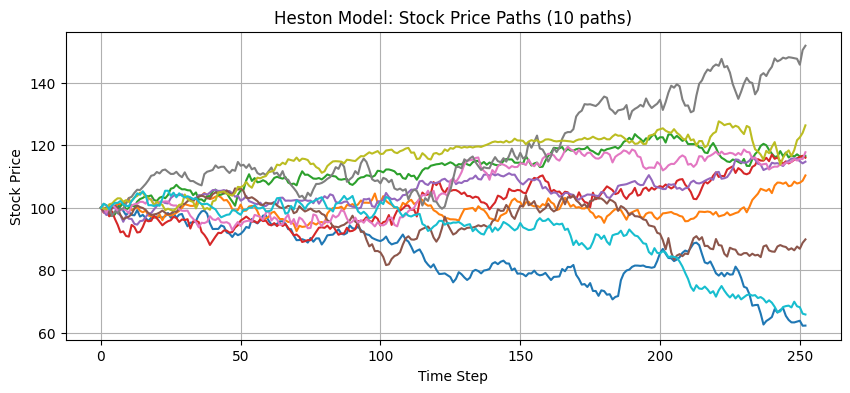

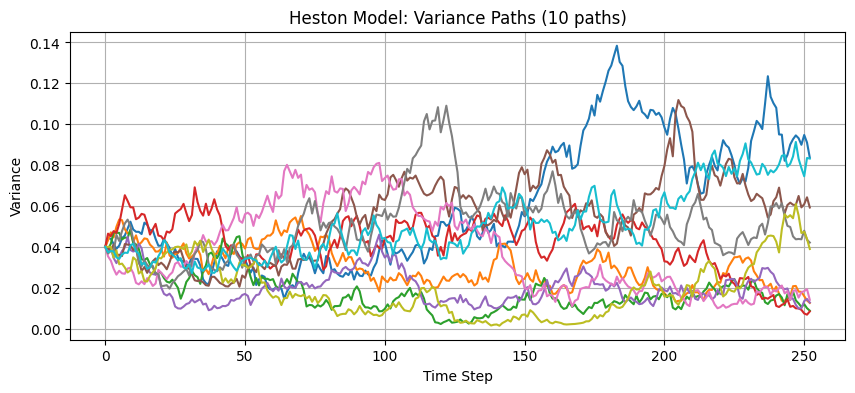

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# -------------------------------
# GBM Simulation
# -------------------------------
def simulate_gbm(S0, mu, sigma, T, N, M, antithetic=False):
    dt = T / N
    size = (M // 2 if antithetic else M, N)
    Z = np.random.normal(size=size)

    if antithetic:
        Z = np.concatenate([Z, -Z], axis=0)

    increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack([np.zeros((M, 1)), log_paths])
    S = S0 * np.exp(log_paths)
    return S


# -------------------------------
# Black-Scholes Closed Form
# -------------------------------
def black_scholes_price(S0, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)


# -------------------------------
# MC Pricing (generic)
# -------------------------------
def european_option_mc(S, K, r, T, option_type='call'):
    ST = S[:, -1]
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * np.mean(payoff)


# -------------------------------
# Variance Reduction (Control Variates)
# -------------------------------
def european_option_control_variate(S, K, r, T, sigma, S0, option_type='call'):
    ST = S[:, -1]
    if option_type == 'call':
        Y = np.maximum(ST - K, 0)
    else:
        Y = np.maximum(K - ST, 0)

    # Black-Scholes price is the control variate
    bs_price = black_scholes_price(S0, K, T, r, sigma, option_type)
    control = ST
    beta = np.cov(Y, control)[0, 1] / np.var(control)
    adjusted_Y = Y - beta * (control - S0 * np.exp(r * T))
    return np.exp(-r * T) * np.mean(adjusted_Y)


# -------------------------------
# Heston Model Simulation (fixed antithetic)
# -------------------------------
def simulate_heston(S0, v0, mu, kappa, theta, sigma_v, rho, T, N, M, antithetic=False):
    dt = T / N
    M_half = M // 2 if antithetic else M

    S = np.zeros((M, N + 1))
    v = np.zeros((M, N + 1))
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(1, N + 1):
        # Generate correlated normal random variables
        Z1 = np.random.normal(size=M_half)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M_half)

        if antithetic:
            Z1 = np.concatenate([Z1, -Z1])
            Z2 = np.concatenate([Z2, -Z2])

        vt_prev = np.maximum(v[:, t - 1], 0)

        v[:, t] = vt_prev + kappa * (theta - vt_prev) * dt + sigma_v * np.sqrt(vt_prev) * np.sqrt(dt) * Z2
        v[:, t] = np.maximum(v[:, t], 0)

        S[:, t] = S[:, t - 1] * np.exp((mu - 0.5 * vt_prev) * dt + np.sqrt(vt_prev * dt) * Z1)

    return S, v


# -------------------------------
# Heston MC Pricing
# -------------------------------
def european_option_heston_mc(S_paths, K, r, T, option_type='call'):
    ST = S_paths[:, -1]
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * np.mean(payoff)


# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    # Common parameters
    S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
    N, M = 252, 100_000

    # ------------------ GBM ------------------
    paths_gbm = simulate_gbm(S0, r, sigma, T, N, M)
    price_gbm_mc = european_option_mc(paths_gbm, K, r, T)
    price_bs = black_scholes_price(S0, K, T, r, sigma)
    price_gbm_antithetic = european_option_mc(simulate_gbm(S0, r, sigma, T, N, M, antithetic=True), K, r, T)
    price_gbm_cv = european_option_control_variate(paths_gbm, K, r, T, sigma, S0)

    # ------------------ Heston ------------------
    v0, kappa, theta, sigma_v, rho = 0.04, 2.0, 0.04, 0.3, -0.7
    paths_heston, v_paths = simulate_heston(S0, v0, r, kappa, theta, sigma_v, rho, T, N, M)
    price_heston_mc = european_option_heston_mc(paths_heston, K, r, T)

    # Antithetic Heston
    paths_heston_anti, _ = simulate_heston(S0, v0, r, kappa, theta, sigma_v, rho, T, N, M, antithetic=True)
    price_heston_antithetic = european_option_heston_mc(paths_heston_anti, K, r, T)

    # Control variate for Heston (using E[ST] under risk-neutral = S0 * exp(rT))
    ST_heston = paths_heston[:, -1]
    payoff_heston = np.maximum(ST_heston - K, 0)
    control = ST_heston
    beta = np.cov(payoff_heston, control)[0, 1] / np.var(control)
    adjusted_Y = payoff_heston - beta * (control - S0 * np.exp(r * T))
    price_heston_cv = np.exp(-r * T) * np.mean(adjusted_Y)

    # ------------------ Results ------------------
    print("=== Option Pricing Comparison ===")
    print(f"Black-Scholes Price (Analytical): {price_bs:.4f}")
    print(f"GBM Monte Carlo Price:           {price_gbm_mc:.4f}")
    print(f"GBM Antithetic Variate Price:    {price_gbm_antithetic:.4f}")
    print(f"GBM Control Variate Price:       {price_gbm_cv:.4f}")
    print(f"Heston Monte Carlo Price:        {price_heston_mc:.4f}")
    print(f"Heston Antithetic Price:         {price_heston_antithetic:.4f}")
    print(f"Heston Control Variate Price:    {price_heston_cv:.4f}")

    # ------------------ Plots ------------------
    plt.figure(figsize=(10, 4))
    plt.plot(paths_heston[:10].T)
    plt.title("Heston Model: Stock Price Paths (10 paths)")
    plt.xlabel("Time Step")
    plt.ylabel("Stock Price")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(v_paths[:10].T)
    plt.title("Heston Model: Variance Paths (10 paths)")
    plt.xlabel("Time Step")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.show()
